In [23]:
import os
import sys

import pandas as pd
from string import punctuation

In [24]:
#%load_ext line_profiler

In [25]:
import nltk

from nltk.tag import StanfordNERTagger

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from nltk.corpus import stopwords

import csv

In [26]:
module_path = os.path.abspath(os.path.join('../code'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utilities import give_source_name, isQuote, clean_up_text
from language_utilities import handle_single_tweet

This Jupyter notebook looks at tweets from 'realDonaldTrump' (October 2016)
This is a working notebook, functions are therefore defined directly in the notebook and not imported from a utiliti python file.

##################
SECTION 1
         <b>Writing .csv files (processed_tokens and vocabulary)</b>
         
Aim: extract words from tweets (tokenize, remove named entities, stopwords, etc...) and tag them (part of speech)

    1. Upload and clean the data
    2. Tokenize and tag
    
##################
SECTION 2
         <b>Using .csv files (processed_tokens and vocabulary)</b>

Aim: investigate the words used (overall, by type...)

    1. Exploring the vocabulary (result: twitter word cloud)
    2. Exploring verb, adj, adv vocabulary (result: sentiment analysis for adj)

#############SECTION 1

# Writing .csv (processed_tokens and vocabulary)

this can be quite time consumming (POS, NER)
#############

## 1. Upload and clean the data
This .csv file is obtained by running the api_script.py for realDonaldTrump
#### Load data

In [27]:
df_trump = pd.read_csv('../data/realDonaldTrump.csv')

#### Feature engineer: sources and clean text

In [28]:
print 'number of unique sources: ', len(df_trump.source.unique())
source_types = df_trump.source.unique()
# human readable (shorter) labels
source_names = ['Web Client', 'iPhone', 'Android', 'iPad',\
                 'Media Studio', 'Instagram', 'Mobile Web']

#add a column with the human readable label
df_trump['type_source'] = map(lambda x: \
                        give_source_name(x, source_types, source_names),\
                        df_trump.source)

#making mask to id the source
mask_android = (df_trump.type_source == 'Android')
mask_iphone = (df_trump.type_source == 'iPhone')

number of unique sources:  7


In [29]:
#retweet signaled with quotation marks
df_trump["isQuote"] = map(isQuote, df_trump.text)
#define a mask to seperate tweets that are retweets from others
mask_android_noquote = ((df_trump.type_source == 'Android') & (df_trump.isQuote==False))
mask_android_isquote = ((df_trump.type_source == 'Android') & (df_trump.isQuote==True))

In [30]:
df_trump['clean_text'] = map(clean_up_text, df_trump.text)

## 2. Tokenize and tag

In [14]:
# Change the paths to point to the directory where you downloaded the Stanford tagger.
os.environ['STANFORD_MODELS'] = "../../Twitter/stanford-ner-2014-06-16/classifiers"
os.environ['CLASSPATH'] = "../../Twitter/stanford-ner-2014-06-16"
st = StanfordNERTagger('english.all.3class.distsim.crf.ser.gz')

In [15]:
wn_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

In [22]:
#remove words not indicative of vocabulary
remove_set = set(punctuation).union(set(stopwords.words('english')))

In [30]:
#time the function
#tweet = df_trump.clean_text[3035]
#%lprun -f handle_single_tweet handle_single_tweet(tweet, remove_set, st, wn_lemmatizer)

In [36]:
#keep only tweets that we think are really from Donald Trump
df_real_trump = df_trump[mask_android_noquote]
print len(df_real_trump)

1159


In [33]:
dict_list = []
vocabulary_list = []
index = 0
for tweet in df_real_trump.clean_text:
    if index%100 == 0: print index
    processed_tokens, dict_by_type = handle_single_tweet(tweet, remove_set, st, wn_lemmatizer)
    vocabulary_list.append(processed_tokens)
    dict_list.append(dict_by_type)
    index += 1

0
100
200
300
400
500
600
700
800
900
1000
1100


In [36]:
key_list = []
for d in dict_list:
    key_list += d.keys()
key_set = set(key_list)
categories_wanted = list(key_set)

In [40]:
def write_csv(filename, list_wanted_information, categories_wanted):
    with open(filename, 'w') as csvfile:
        fieldnames = categories_wanted
        writer = csv.DictWriter(csvfile, fieldnames)
        writer.writeheader()
        for d in list_wanted_information:
            writer.writerow(d)

In [41]:
write_csv('../data/processed_tokens.csv', dict_list, categories_wanted)

In [47]:
with open('../data/vocabulary.csv', 'w') as f:
    for tweet_vocab in vocabulary_list:
        f.write('\n' + ','.join(tweet_vocab))

#############SECTION 2

# Using saved .csv (processed_tokens and vocabulary)

#############

In [87]:
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import csv
import re
from wordcloud import WordCloud
from PIL import Image

In [219]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [34]:
from textblob import TextBlob

In [3]:
def bar_from_counter(wordtype, counter, top_n_words, figsize=(5,6)):
    list_words = [word for word, count in counter.most_common(top_n_words)][::-1]
    list_words_count = [count for word, count in counter.most_common(top_n_words)][::-1]
    fig, ax = plt.subplots(figsize=figsize)

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.set_xlabel('Count of {}'.format(wordtype), fontsize=16)

    ax.set_yticks(np.arange(top_n_words))
    ax.set_yticklabels(list_words)
    ax.barh(range(top_n_words), list_words_count, align='center')
    plt.show()

In [266]:
def make_wordcloud(count, top_n_words=100):
    '''
    count: counter with key word, value is count
    '''
    #prepare the string to be fed in to the word cloud generator
    text = ''
    for word, wordcount in count.most_common(top_n_words):
        text += (' ' + word) * wordcount
        
    import random
    def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        '''
        here I choose dark gray
        --> http://www.december.com/html/spec/colorhsl.html
        '''
        return "hsl(0, 0%%, %d%%)" % random.randint(3, 23)

    image_mask = np.array(Image.open('../images/bird.jpg'))
    
    wordc = WordCloud(background_color="white", mask=image_mask)
    wordc.generate(text)
    
    plt.figure()
    plt.axis("off")
    plt.imshow(wordc.recolor(color_func=grey_color_func, random_state=3))
    plt.imshow(image_mask, alpha=0.3)
    plt.show()

In [40]:
def get_sentiment_polarity(text):
    blob = TextBlob(text)
    return blob.polarity, blob.subjectivity

In [55]:
def study_sentiment(polarity_list, mid_point=0):
    '''
    The polarity score is a float within the range [-1.0, 1.0].
    The subjectivity is a float within the range [0.0, 1.0] 
    where 0.0 is very objective and 1.0 is very subjective.
    '''
    polarity_array = np.array(polarity_list)
    mean = np.mean(polarity_array)
    std = np.std(polarity_array)
    frac_positive = sum(polarity_array>mid_point)*1./len(polarity_array)
    frac_negative = sum(polarity_array<mid_point)*1./len(polarity_array)
    return mean, std, frac_positive,frac_negative

## 1. Exploring the vocabulary

In [79]:
vocabulary_list = open('../data/vocabulary.csv', 'r').read().split(',')

In [80]:
print 'total number of words : ', len(vocabulary_list)

total number of words :  10211


In [268]:
counter_vocab = Counter(vocabulary_list)
print('number of distinct words: {}'.format(len(counter_vocab)))

number of distinct words: 3254


In [271]:
del counter_vocab["n't"]

<IPython.core.display.Javascript object>


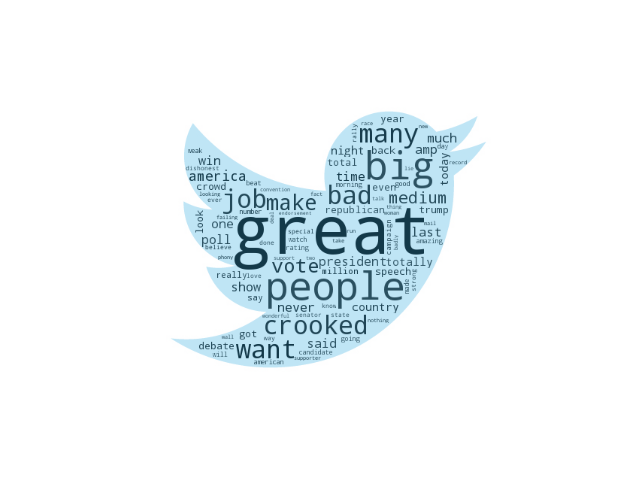

In [272]:
make_wordcloud(counter_vocab)

## 2. Exploring the verb, adj, adv vocabulary

In [9]:
#just getting the headers, not the most efficient solution out there...
df = pd.read_csv('../data/processed_tokens.csv')
df.columns

Index([u'PRP$', u'VBG', u'VBD', u'VBN', u'VBP', u'WDT', u'JJ', u'WP', u'VBZ',
       u'DT', u'RP', u'NN', u'FW', u'PRP', u'RB', u':', u'NNS', u'NNP', u'VB',
       u'WRB', u'CC', u'PDT', u'RBR', u'CD', u'EX', u'IN', u'WP$', u'MD',
       u'NNPS', u'JJS', u'JJR', u'UH'],
      dtype='object')

In [10]:
#read the file into a dictionary
reader = csv.DictReader(open('../data/processed_tokens.csv','r'), fieldnames=df.columns)
d = defaultdict(str)
for row in reader:
    for field in df.columns:
        d[field]+=row[field]

In [11]:
#clean up the dictionary to have a list of words as strings
word_dict = {}
for key in d:
    word_dict[key] = [item for item in re.findall('\w*',d[key]) if len(item) > 1]

#### Zooming in on adverbs, adjectifs and verbs

Brief overview of nltk tags of interest
- JJ: adjective
- JJR: comparative
- JJS: superlative
- RB: adverb
- RBR

In [12]:
adj_list = []
adv_list = []
verb_list = []
for tag in ['JJ', 'JJR', 'JJS']:
    adj_list.extend(word_dict[tag])
for tag in ['RBR', 'RB']:
    adv_list.extend(word_dict[tag])
    
adj_adv_list = adj_list + adv_list

for tag in ['VB', 'VBZ', 'VBG', u'VBD', u'VBN', u'VBP']:
    verb_list.extend(word_dict[tag])

In [13]:
count_adj = Counter(adj_list)
count_adv = Counter(adv_list)
count_verb = Counter(verb_list)

In [14]:
count_adv.most_common(20)

[('never', 45),
 ('totally', 41),
 ('even', 33),
 ('just', 30),
 ('really', 30),
 ('back', 26),
 ('badly', 23),
 ('ever', 22),
 ('very', 21),
 ('much', 20),
 ('far', 15),
 ('well', 15),
 ('now', 14),
 ('also', 14),
 ('yet', 12),
 ('not', 12),
 ('soon', 12),
 ('almost', 12),
 ('still', 9),
 ('always', 9)]

In [15]:
count_adj.most_common(20)

[('great', 131),
 ('big', 72),
 ('many', 71),
 ('bad', 57),
 ('last', 42),
 ('good', 34),
 ('total', 30),
 ('much', 24),
 ('dishonest', 23),
 ('weak', 22),
 ('new', 21),
 ('special', 20),
 ('strong', 19),
 ('wonderful', 19),
 ('negative', 18),
 ('nice', 17),
 ('false', 16),
 ('fantastic', 15),
 ('amazing', 15),
 ('presidential', 14)]

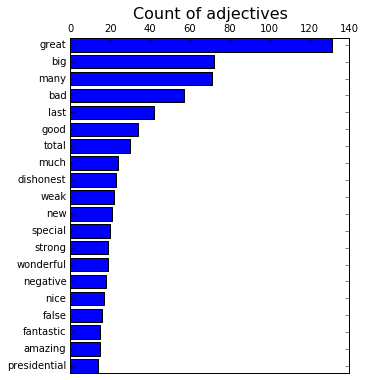

In [16]:
wordtype = 'adjectives'
counter = count_adj
top_n_words = 20
bar_from_counter(wordtype, counter, top_n_words, figsize=(5,6))

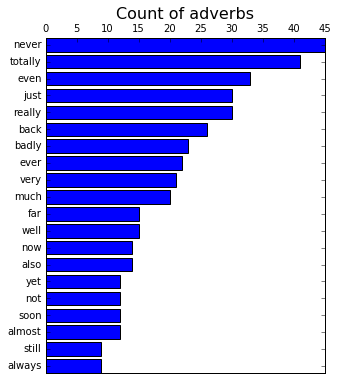

In [17]:
wordtype = 'adverbs'
counter = count_adv
top_n_words = 20
bar_from_counter(wordtype, counter, top_n_words, figsize=(5,6))

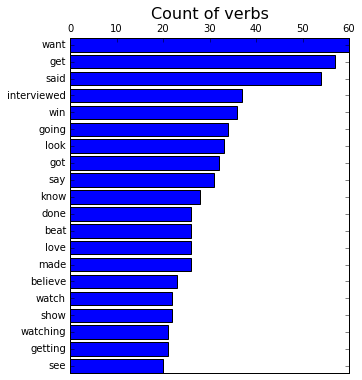

In [18]:
wordtype = 'verbs'
counter = count_verb
top_n_words = 20
bar_from_counter(wordtype, counter, top_n_words, figsize=(5,6))

#### Sentiment analysis with text blob
- For all Trump tweets

In [41]:
sentiment_analysis = map(get_sentiment_polarity, df_trump.clean_text.values)
polarity_list = map(lambda x:x[0], sentiment_analysis)
sentiment_list = map(lambda x:x[1], sentiment_analysis)

In [64]:
mean, std, frac_positive,frac_negative = study_sentiment(polarity_list)
print 'Studying Polarity'
print 'Average: {0:.2f} +/- {1:.2f} | fraction of positive: {2:.2f} | fraction of negative: {3:.2f}'\
        .format(mean, std, frac_positive,frac_negative)
    
mean, std, frac_positive,frac_negative = study_sentiment(sentiment_list, 0.5)
print 'Studying Sentiment'
print 'Average: {0:.2f} +/- {1:.2f} | fraction of subjective: {2:.2f} | fraction of objective: {3:.2f}'\
        .format(mean, std, frac_positive,frac_negative)

Studying Polarity
Average: 0.14 +/- 0.36 | fraction of positive: 0.47 | fraction of negative: 0.21
Studying Sentiment
Average: 0.40 +/- 0.31 | fraction of subjective: 0.39 | fraction of objective: 0.54


- For 'real' Trump tweets

In [66]:
sentiment_analysis = map(get_sentiment_polarity, df_real_trump.clean_text.values)
polarity_list = map(lambda x:x[0], sentiment_analysis)
sentiment_list = map(lambda x:x[1], sentiment_analysis)

In [67]:
mean, std, frac_positive,frac_negative = study_sentiment(polarity_list)
print 'Studying Polarity'
print 'Average: {0:.2f} +/- {1:.2f} | fraction of positive: {2:.2f} | fraction of negative: {3:.2f}'\
        .format(mean, std, frac_positive,frac_negative)
    
mean, std, frac_positive,frac_negative = study_sentiment(sentiment_list, 0.5)
print 'Studying Sentiment'
print 'Average: {0:.2f} +/- {1:.2f} | fraction of subjective: {2:.2f} | fraction of objective: {3:.2f}'\
        .format(mean, std, frac_positive,frac_negative)

Studying Polarity
Average: 0.13 +/- 0.36 | fraction of positive: 0.56 | fraction of negative: 0.30
Studying Sentiment
Average: 0.50 +/- 0.26 | fraction of subjective: 0.49 | fraction of objective: 0.43


- For adjectives

In [71]:
upgraded_count = {}
for adj in count_adj:
    adjective_to_study = TextBlob(adj)
    d_nested = {}
    d_nested['count'] = count_adj[adj]
    d_nested['polarity'] = adjective_to_study.polarity
    d_nested['subjectivity'] = adjective_to_study.subjectivity
    upgraded_count[adj] = d_nested

<IPython.core.display.Javascript object>


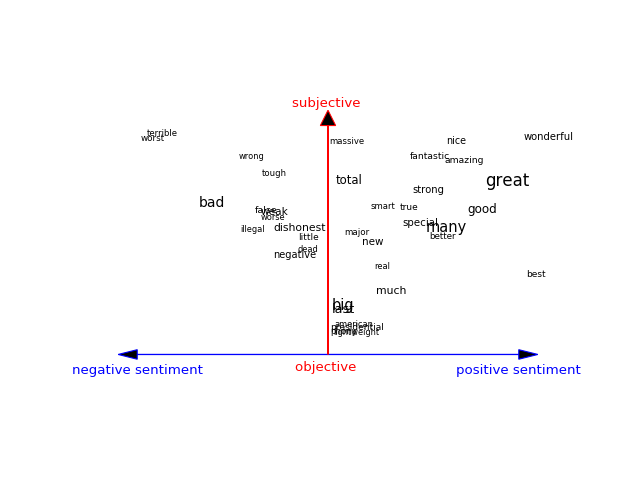

In [259]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlabel('polarity')
ax.set_xlim([-1.3,1.3])
ax.set_ylabel('subjectivity')
ax.set_ylim([-0.2,1.2])
plt.axis('off')
ax.text(-1,-0.2, 'negative sentiment', size=12, color='blue', horizontalalignment='center')
ax.text(1,-0.2, 'positive sentiment', size=12, color='blue', horizontalalignment='center')
ax.arrow(0, -0.1, 1, 0, head_width=0.05, head_length=0.1, fc='k', ec='b')
ax.arrow(0, -0.1, -1, 0, head_width=0.05, head_length=0.1, fc='k', ec='b')

ax.text(0,-0.2, 'objective ', size=12, color='r', verticalalignment='bottom', horizontalalignment='center')
ax.text(0, 1.25, 'subjective ', size=12, color='r', verticalalignment='top', horizontalalignment='center')
ax.arrow(0, -0.1, 0, 1.2, head_width=0.08, head_length=0.08, fc='k', ec='r')

for word in upgraded_count:
    size = upgraded_count[word]['count']
    x_pol = upgraded_count[word]['polarity'] + random.random()/20
    y_subj = upgraded_count[word]['subjectivity'] + random.random()/20
    if size >10:
        ax.text(x_pol, y_subj, word, fontsize=(15.*np.log(size))/np.log(131))